In [1]:
!pip install langchain langchain_core langchain_community langgraph langchain_openai

In [2]:
from google.colab import userdata
import os
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

In [3]:
from langchain_openai.chat_models import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

In [4]:
from typing_extensions import TypedDict
class State(TypedDict):
  application: str
  experience_level: str
  skill_match : str
  response: str

In [5]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(State)

In [6]:
from langchain_core.prompts import ChatPromptTemplate

In [7]:
def categorize_experience(state: State) -> State:
  print("\nCategorizing the experience level of candidate : ")
  prompt = ChatPromptTemplate.from_template(
      "Based on the following job application, categorize the candidate as 'Entry-level', 'Mid-level' or 'Senior-level'"
      "Application : {application}"
  )
  chain = prompt | llm
  experience_level = chain.invoke({"application": state["application"]}).content
  print(f"Experience Level : {experience_level}")
  return {"experience_level" : experience_level}

def assess_skillset(state: State) -> State:
  print("\nAssessing the skillset of candidate : ")
  prompt = ChatPromptTemplate.from_template(
      "Based on the job application for a Python Developer, assess the candidate's skillset"
      "Respond with either 'Match' or 'No Match'"
      "Application : {application}"
  )
  chain = prompt | llm
  skill_match = chain.invoke({"application": state["application"]}).content
  print(f"Skill Match : {skill_match}")
  return {"skill_match" : skill_match}

def schedule_hr_interview(state: State) -> State:
  print("\nScheduling the interview : ")
  return {"response" : "Candidate has been shortlisted for an HR interview."}

def escalate_to_recruiter(state: State) -> State:
  print("Escalating to recruiter")
  return {"response" : "Candidate has senior-level experience but doesn't match job skills."}

def reject_application(state: State) -> State:
  print("Sending rejecting email")
  return {"response" : "Candidate doesn't meet JD and has been rejected."}

In [8]:
workflow.add_node("categorize_experience", categorize_experience)
workflow.add_node("assess_skillset", assess_skillset)
workflow.add_node("schedule_hr_interview", schedule_hr_interview)
workflow.add_node("escalate_to_recruiter", escalate_to_recruiter)
workflow.add_node("reject_application", reject_application)

In [9]:
def route_app(state: State) -> str:
  if(state["skill_match"] == "Match"):
    return "schedule_hr_interview"
  elif(state["experience_level"] == "Senior-level"):
    return "escalate_to_recruiter"
  else:
    return "reject_application"

In [10]:
workflow.add_edge("categorize_experience", "assess_skillset")
workflow.add_conditional_edges("assess_skillset", route_app)

In [11]:
workflow.add_edge(START, "categorize_experience")
workflow.add_edge("assess_skillset", END)
workflow.add_edge("escalate_to_recruiter", END)
workflow.add_edge("reject_application", END)
workflow.add_edge("schedule_hr_interview", END)

In [12]:
app = workflow.compile()

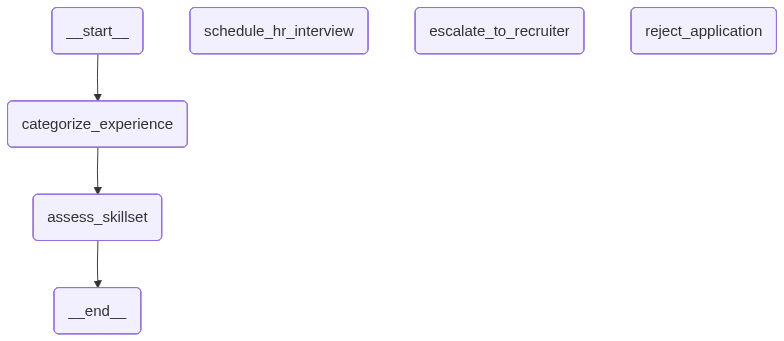

In [13]:
from IPython.display import Image, display

display(
    Image(
        app.get_graph().draw_mermaid_png()
    )
)

In [14]:
def run_candidate_screening(application: str):
  results = app.invoke({"application" : application})
  return {
      "experience_level" : results["experience_level"],
      "skill_match" : results["skill_match"],
      "response" : results["response"]
  }

To use an open-source model from Hugging Face, you'll typically need the `transformers` library and potentially others depending on the model. You'll also need to specify the model you want to use.

In [15]:
# # You might need to install these libraries if you haven't already
# # !pip install transformers accelerate

# from transformers import AutoModelForCausalLM, AutoTokenizer
# from langchain_community.llms import HuggingFacePipeline
# import torch

# # Specify the model you want to use
# model_name = "gpt2" # Example: a small, readily available model

# # Load the tokenizer and model
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForCausalLM.from_pretrained(model_name)

# # Create a HuggingFace pipeline
# pipe = pipeline(
#     "text-generation",
#     model=model,
#     tokenizer=tokenizer,
#     max_new_tokens=100, # Adjust as needed
#     device=0 if torch.cuda.is_available() else -1 # Use GPU if available
# )

# # Create a LangChain HuggingFacePipeline instance
# llm_open_source = HuggingFacePipeline(pipeline=pipe)

# # Now you can use llm_open_source in your LangChain workflows instead of ChatOpenAI
# # For example, you would modify the 'chain' in your functions like categorize_experience
# # chain = prompt | llm_open_source

In [16]:
application_text = "I have 10 years of experience in software engineering with expertise in JAVA"
results = run_candidate_screening(application_text)
print("\n\nComputed Results :")
print(f"Application: {application_text}")
print(f"Experience Level: {results['experience_level']}")
print(f"Skill Match: {results['skill_match']}")
print(f"Response: {results['response']}")


Categorizing the experience level of candidate : 
Experience Level : Based on the job application stating that the candidate has 10 years of experience in software engineering, they would be categorized as 'Senior-level'.

Assessing the skillset of candidate : 
Skill Match : No Match
Sending rejecting email


Computed Results :
Application: I have 10 years of experience in software engineering with expertise in JAVA
Experience Level: Based on the job application stating that the candidate has 10 years of experience in software engineering, they would be categorized as 'Senior-level'.
Skill Match: No Match
Response: Candidate doesn't meet JD and has been rejected.


**Note:** Using larger open-source models might require significant computational resources (GPU memory, processing power) that may not be available in a free Colab environment. You might need to consider using a smaller model or a paid Colab tier/other cloud platform.

You would need to replace `ChatOpenAI()` with `llm_open_source` in the relevant parts of your workflow where you want to use the open-source model.

In [17]:
application_text = "I have 1 year of experience in software engineering with expertise in JAVA"
results = run_candidate_screening(application_text)
print("\n\nComputed Results :")
print(f"Application: {application_text}")
print(f"Experience Level: {results['experience_level']}")
print(f"Skill Match: {results['skill_match']}")
print(f"Response: {results['response']}")


Categorizing the experience level of candidate : 
Experience Level : Based on the information provided in the job application, the candidate can be categorized as 'Entry-level' due to having only 1 year of experience in software engineering.

Assessing the skillset of candidate : 
Skill Match : No Match
Sending rejecting email


Computed Results :
Application: I have 1 year of experience in software engineering with expertise in JAVA
Experience Level: Based on the information provided in the job application, the candidate can be categorized as 'Entry-level' due to having only 1 year of experience in software engineering.
Skill Match: No Match
Response: Candidate doesn't meet JD and has been rejected.


In [18]:
application_text = "I have experience in software engineering with expertise in Python"
results = run_candidate_screening(application_text)
print("\n\nComputed Results :")
print(f"Application: {application_text}")
print(f"Experience Level: {results['experience_level']}")
print(f"Skill Match: {results['skill_match']}")
print(f"Response: {results['response']}")


Categorizing the experience level of candidate : 
Experience Level : Based on the information provided in the application, it is insufficient to definitively categorize the candidate as 'Entry-level', 'Mid-level', or 'Senior-level'. The candidate mentions experience in software engineering and expertise in Python, but does not provide specific details about the length of their experience, the complexity of projects worked on, leadership roles, or any other relevant skills.

To categorize appropriately, additional information would be needed, such as:

- Number of years of experience in software engineering
- Types and scale of projects worked on
- Any leadership or mentorship roles taken on
- Additional skills and technologies used

Without this context, it is not possible to accurately classify the candidate's level of experience.

Assessing the skillset of candidate : 
Skill Match : Match

Scheduling the interview : 


Computed Results :
Application: I have experience in software en

In [19]:
application_text = "I have 5 years of experience in software engineering with expertise in C++"
results = run_candidate_screening(application_text)
print("\n\nComputed Results :")
print(f"Application: {application_text}")
print(f"Experience Level: {results['experience_level']}")
print(f"Skill Match: {results['skill_match']}")
print(f"Response: {results['response']}")


Categorizing the experience level of candidate : 
Experience Level : Based on the information provided in the job application, the candidate would be categorized as 'Mid-level'. Typically, 'Mid-level' positions require around 3 to 5 years of experience, which aligns with the candidate's 5 years in software engineering.

Assessing the skillset of candidate : 
Skill Match : No Match
Sending rejecting email


Computed Results :
Application: I have 5 years of experience in software engineering with expertise in C++
Experience Level: Based on the information provided in the job application, the candidate would be categorized as 'Mid-level'. Typically, 'Mid-level' positions require around 3 to 5 years of experience, which aligns with the candidate's 5 years in software engineering.
Skill Match: No Match
Response: Candidate doesn't meet JD and has been rejected.
